# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
# matplotlib.rcParams.update({'font.size': 16,
#                             # 'figure.figsize': (16, 8), # don't need with %matplotlib notebook?
#                             'axes.titlesize': 16,
#                             'axes.labelsize': 16,
#                             'xtick.labelsize': 14,
#                             'ytick.labelsize': 14,
#                             'legend.fontsize': 14})

# rdtools import
import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

# Load/merge weather and performance data

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

In [2]:
weather_file = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
pv_file = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1429.csv')

In [3]:
weather_cols = ['Diffuse_Wm2', 'Direct_Wm2', 'Global_Wm2', 'Date-Time']
pv_cols = ['inv1_ac_power', 'inv2_ac_power', 'poa_irradiance', 'Date-Time']

In [4]:
weather_data = pd.read_csv(weather_file, parse_dates=['Date-Time'], usecols=weather_cols, index_col=['Date-Time'])

In [5]:
pv_data = pd.read_csv(pv_file, parse_dates=['Date-Time'], usecols=pv_cols, index_col=['Date-Time'])

In [6]:
pv_data.index[0], pv_data.index[-1]

(Timestamp('2016-02-25 22:31:00'), Timestamp('2017-04-06 22:30:00'))

In [7]:
data = pv_data.join(weather_data)

In [8]:
data.index = data.index.tz_localize('Etc/GMT+7')

In [9]:
data = data[~data.index.duplicated(keep='first')]

In [10]:
data = data.reindex(
    pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')
).fillna(0)

In [11]:
data.head()

,inv1_ac_power,inv2_ac_power,poa_irradiance,Diffuse_Wm2,Direct_Wm2,Global_Wm2
2016-02-25 22:31:00-07:00,-2.244121,0.0,-2.317497,-3.939134,-0.396433,-2.695221
2016-02-25 22:32:00-07:00,-2.277532,0.0,-2.317497,-3.986710,-0.384538,-2.695194
2016-02-25 22:33:00-07:00,-2.351175,0.0,-2.317497,-4.025656,-0.363480,-2.663026
2016-02-25 22:34:00-07:00,-2.498224,0.0,-2.317497,-3.992474,-0.344804,-2.631277
2016-02-25 22:35:00-07:00,-2.424602,0.0,-2.317497,-4.095499,-0.576361,-2.667464


# Look at irradiance and cloudy days using PV_Lib detection method

<IPython.core.display.Javascript object>


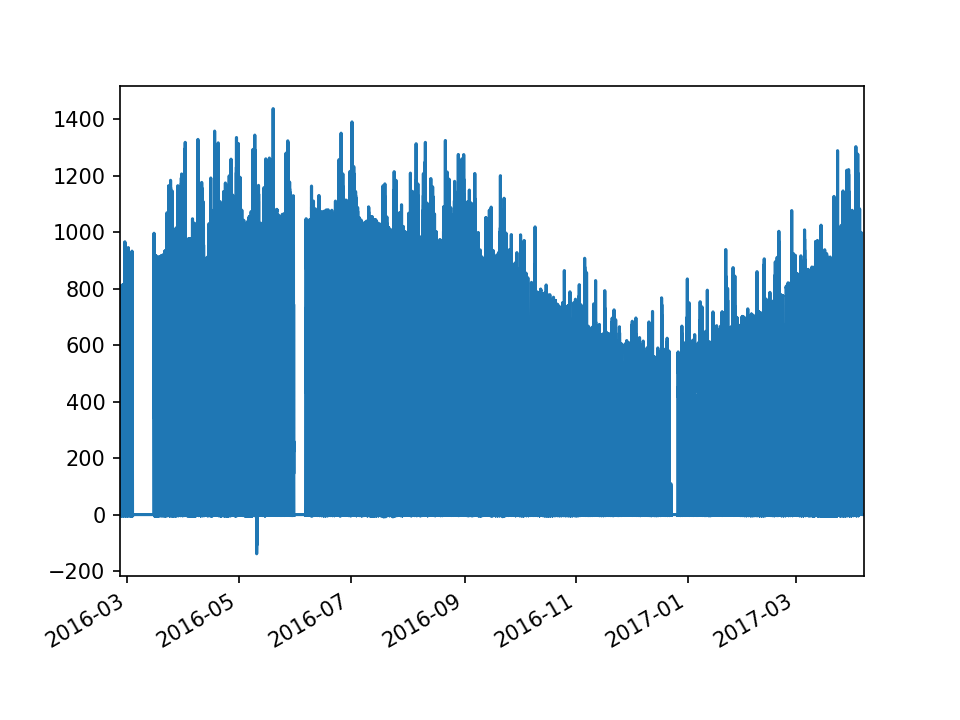

In [12]:
fig, ax = plt.subplots()
data['Global_Wm2'].plot(ax=ax)

#### Picking a random week where no data is missing.  Will use the detect_clearsky method from RdTools/PV_Lib to explore the weather patterns and correlations.

In [13]:
start_date = '2016-07-01'
end_date = '2016-08-01'
sample = data[(data.index >= start_date) & (data.index < end_date)].copy()# & (data.index.day <= 14)].copy()

<IPython.core.display.Javascript object>


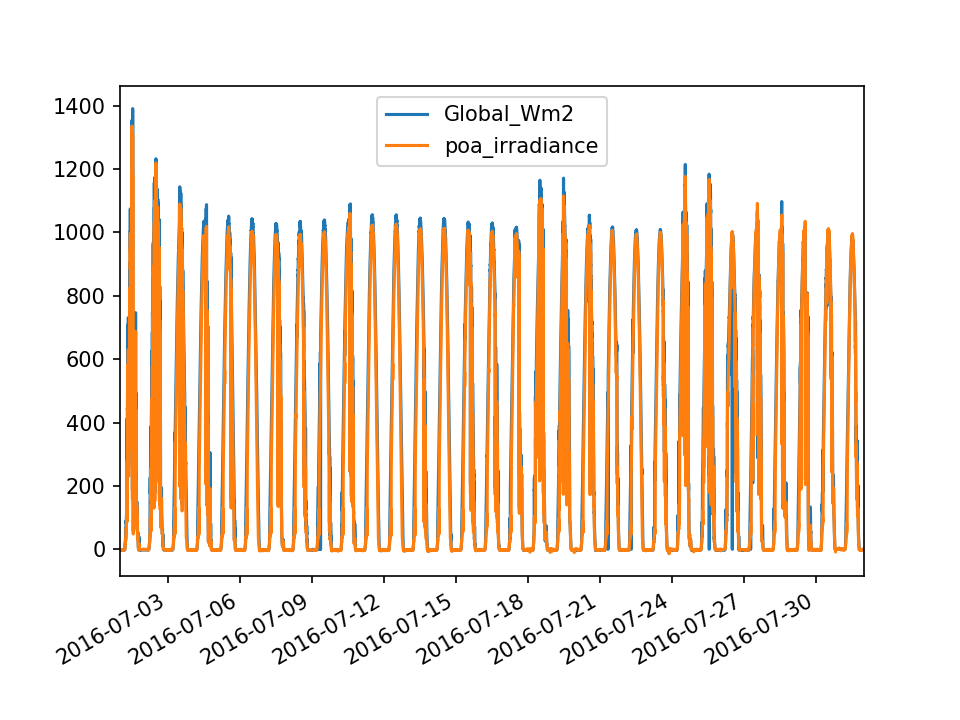

In [14]:
sample.plot(y=['Global_Wm2', 'poa_irradiance'])

Set up PVSystem/Location for using PV_Lib.

In [15]:
site_azimuth = 180
site_elevation = 1658
site_tilt = 35
site_lat = 35.0549
site_lon = -106.5433

In [16]:
rtc_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=site_tilt, surface_azimuth=site_azimuth)
rtc_loc = pvlib.location.Location(site_lat, site_lon, altitude=site_elevation)
rtc = pvlib.pvsystem.LocalizedPVSystem(pvsystem=rtc_no_loc, location=rtc_loc)

#### Get clear sky irradiance values from model (PV_Lib).

In [17]:
clear_skies = rtc_loc.get_clearsky(sample.index)
clear_skies = pd.Series(clear_skies['ghi'], index=sample.index)

#### Detect clear skies using model and measured data for sample week.

In [18]:
# Some NaNs present at nightime or missing values.  Linearly interpolating values for now.
# sample.fillna(sample.interpolate(), inplace=True)

In [19]:
window = 10 # 10 min windows, 'standard' from original paper

In [20]:
is_clear = pvlib.clearsky.detect_clearsky(sample['Global_Wm2'], clear_skies, sample.index, window)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


#### Visualize clear sky times versus the GHI (which is used to detect clear skies) and POA

<IPython.core.display.Javascript object>


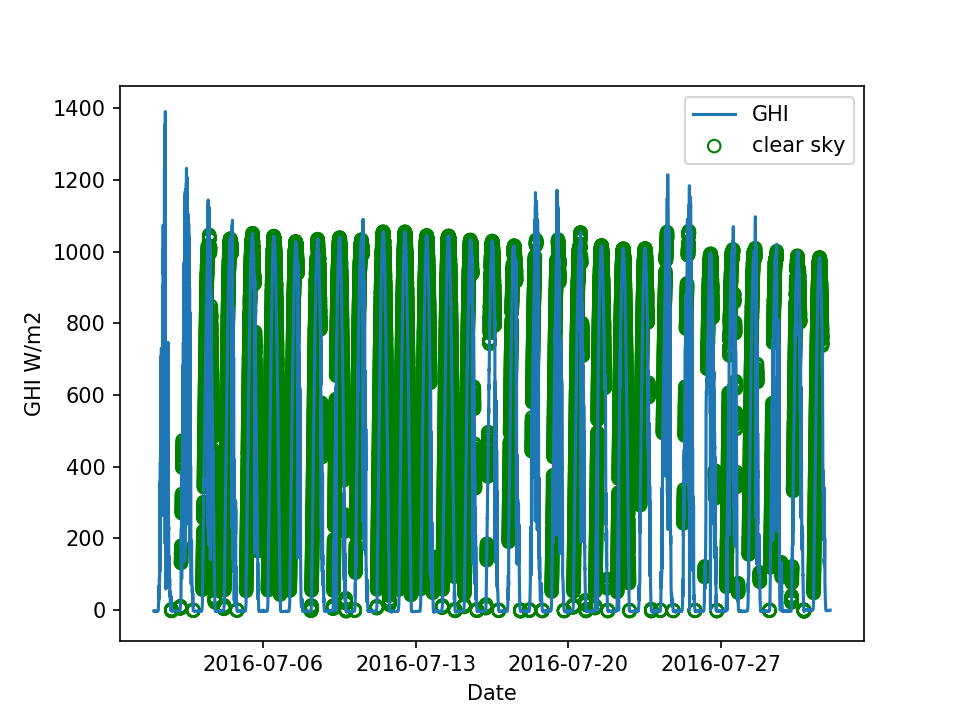

In [21]:
fig, ax = plt.subplots()
_ = ax.plot(sample.index, sample['Global_Wm2'], label='GHI')
# sample.plot(y=['Global_Wm2'], ax=ax, label='GHI', legend=True)
_ = ax.scatter(x=sample[is_clear].index, y=sample['Global_Wm2'][is_clear], 
           facecolors='none', edgecolors='green', label='clear sky')
_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('GHI W/m2')
_ = ax.legend()

#### Looks like POA irradiance and GHI measurements correlate nicely.  Will investigate the correlation on clear sky periods, not clear sky periods, and all periods.

<IPython.core.display.Javascript object>


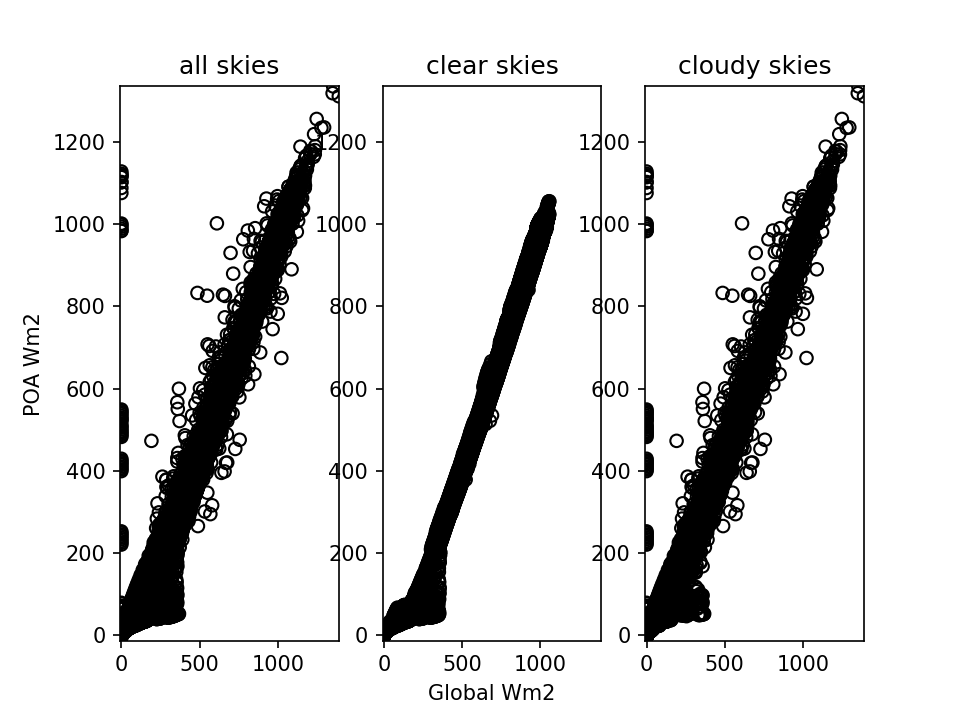

(-14.19467, 1335.7470000000001)

In [22]:
fig, axes = plt.subplots(ncols=3, nrows=1)
ax = axes[0]
ax.scatter(x=sample['Global_Wm2'], y=sample['poa_irradiance'], facecolors='none', edgecolors='black')
ax.set_title('all skies')
ax.set_ylabel('POA Wm2')
ax.set_xlim([sample['Global_Wm2'].min(), sample['Global_Wm2'].max()])
ax.set_ylim([sample['poa_irradiance'].min(), sample['poa_irradiance'].max()])
ax = axes[1]
ax.scatter(x=sample['Global_Wm2'][is_clear], y=sample['poa_irradiance'][is_clear], 
           facecolors='none', edgecolors='black')
ax.set_title('clear skies')
ax.set_xlabel('Global Wm2')
ax.set_xlim([sample['Global_Wm2'].min(), sample['Global_Wm2'].max()])
ax.set_ylim([sample['poa_irradiance'].min(), sample['poa_irradiance'].max()])
ax = axes[2]
ax.scatter(x=sample['Global_Wm2'][~is_clear], y=sample['poa_irradiance'][~is_clear], 
           facecolors='none', edgecolors='black')
ax.set_title('cloudy skies')
ax.set_xlim([sample['Global_Wm2'].min(), sample['Global_Wm2'].max()])
ax.set_ylim([sample['poa_irradiance'].min(), sample['poa_irradiance'].max()])

<IPython.core.display.Javascript object>


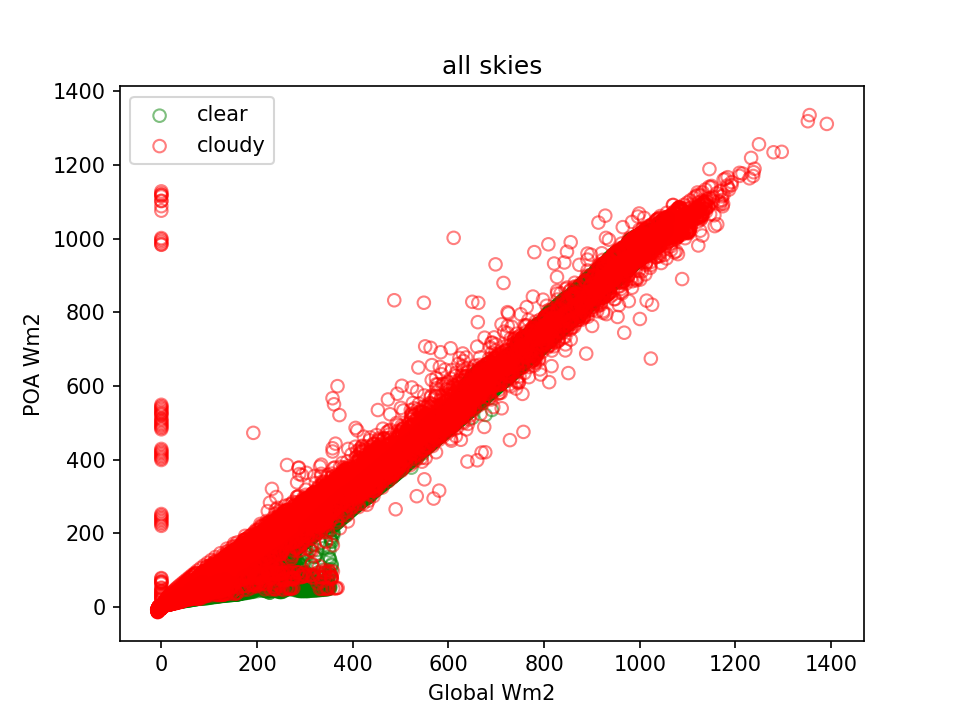

In [23]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(x=sample['Global_Wm2'][is_clear], y=sample['poa_irradiance'][is_clear == True], 
           facecolors='none', edgecolors='green', alpha=0.5, label='clear')
ax.scatter(x=sample['Global_Wm2'][~is_clear], y=sample['poa_irradiance'][is_clear == False], 
           facecolors='none', edgecolors='red', alpha=0.5, label='cloudy')
ax.set_title('all skies')
ax.set_ylabel('POA Wm2')
ax.set_xlabel('Global Wm2')
ax.legend()

POA vs GHI doesn't correlate differently between clear and cloudy skies based on visualization.

#### Look at meteorological irradiance measures (GHI, DHI, DNI) for clear and cloudy days to check for discernable pattern.

<IPython.core.display.Javascript object>


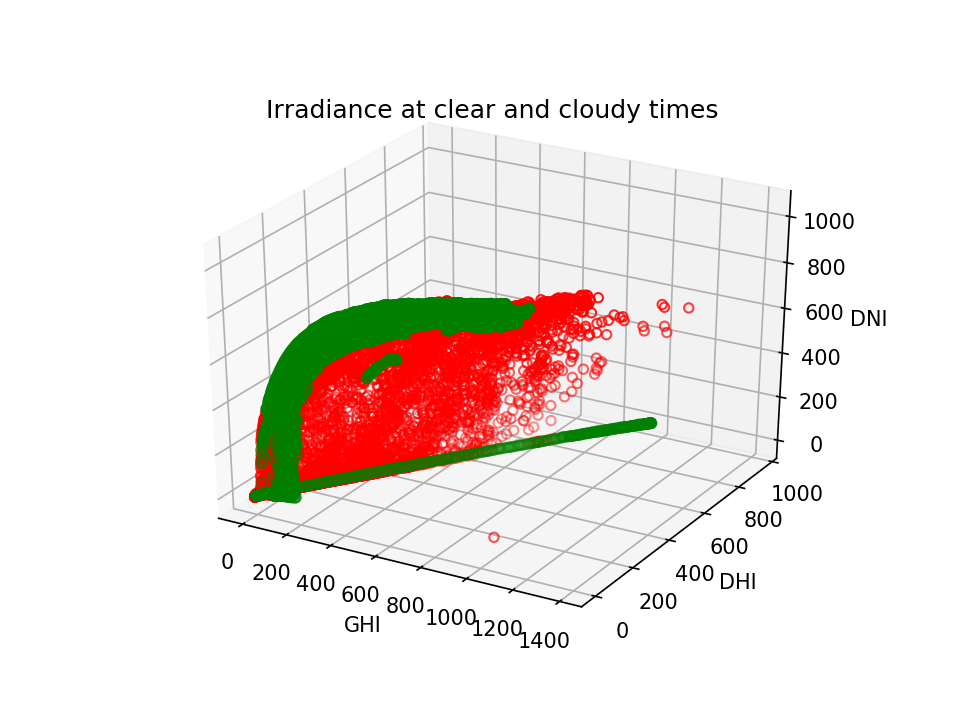

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sample['Global_Wm2'][is_clear], 
           sample['Diffuse_Wm2'][is_clear], 
           sample['Direct_Wm2'][is_clear], facecolors='none', edgecolors='green')
ax.scatter(sample['Global_Wm2'][~is_clear], 
           sample['Diffuse_Wm2'][~is_clear], 
           sample['Direct_Wm2'][~is_clear], facecolors='none', edgecolors='red')
ax.set_xlabel('GHI')
ax.set_ylabel('DHI')
ax.set_zlabel('DNI')
ax.set_title('Irradiance at clear and cloudy times')

Looks like clear days follow a tighter trend than cloudy days based on available data.

#### Make quick decision tree out of curiosity.

In [25]:
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn import ensemble

In [26]:
X = sample[['Global_Wm2', 'Diffuse_Wm2', 'Direct_Wm2', 'poa_irradiance']].values

In [27]:
y = is_clear.astype(int).values

In [28]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=1)

In [29]:
dt = tree.DecisionTreeClassifier(max_depth=5)

In [30]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [31]:
y_pred = dt.predict(X_test)

In [32]:
metrics.accuracy_score(y_test, y_pred)

0.94668458781362008

In [33]:
tree.export_graphviz(dt, out_file='ghi_dhi_dni.dot', feature_names=['Global_Wm2', 'Diffuse_Wm2', 'Direct_Wm2', 'POA_Wm2'])

# Investigate the clear sky detection criterion

#### Curious as to how many points pass 1, 2, 3, 4, or all 5 tests (and which tests)

In [34]:
is_clear, components_dict, alpha = pvlib.clearsky.detect_clearsky(sample['Global_Wm2'], clear_skies, 
                                                                  sample.index, window, return_components=True)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


In [35]:
components_df = pd.DataFrame(components_dict)

In [36]:
components_df = components_df.astype(int)

In [37]:
components_df.head()

,mean_diff,max_diff,line_length,slope_nstd,slope_max,mean_nan,windows
0,1,1,1,1,1,0,0
1,1,1,1,1,1,0,0
2,1,1,1,1,1,0,0
3,1,1,1,1,1,0,0
4,1,1,1,1,1,0,0


Windows: periods where all 5 tests were passed.
Mean_nan: not outlined in paper, but checks if mean of GHI is 0 or nan.

In [38]:
components_cols = ['mean_diff', 'max_diff', 'line_length', 'slope_nstd', 'slope_max']
components_pcts = pd.Series(index=components_cols, data=np.zeros(len(components_cols)))
for comp in components_cols:
    # print(comp)
    pct_pass = components_df[comp].sum() / len(components_df[comp])
    # pcts.append(pct_pass)
    components_pcts[comp] = pct_pass

<IPython.core.display.Javascript object>


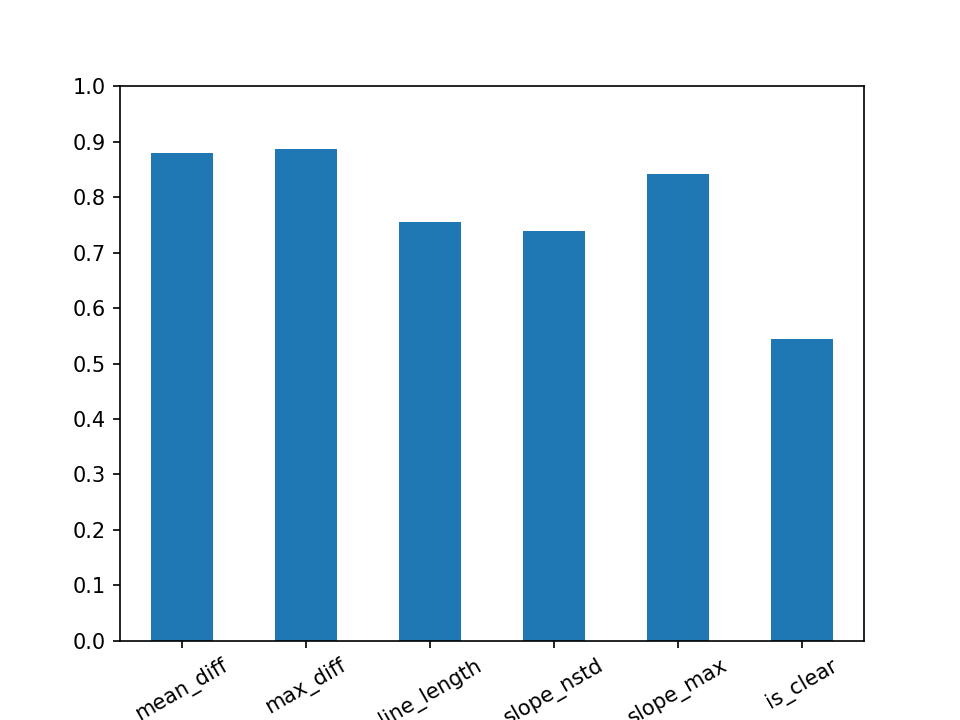

In [39]:
components_pcts['is_clear'] = len(is_clear[is_clear]) / len(is_clear[~is_clear])
fig, ax = plt.subplots()
components_pcts.plot(kind='bar', rot=30)
ax.set_yticks([i / 10 for i in range(11)])

Tests are passed most of the time, with line_lenth and slope_nstd being the most strict.  This is (almost definitely) directly tied to the tolerances used with detect_clearsky method.  Raises the questions - should all tests be as strict as the others?  Are certain tests more important than others?  Should a sky be clear if it passes 1 or 2 'critical' tests but fails a 'supplementary' test?

mean_nan is mostly checking for night times/missing measurements.  Dropping everything that doesn't pass this test to focus on tests from Reno-Hansen paper.

In [40]:
components_df['n_tests_passed'] = components_df[components_cols].sum(axis=1)

In [41]:
components_df['n_tests_passed'].value_counts()

5    31193
4     3379
2     3195
1     2965
0     2437
3     1462
Name: n_tests_passed, dtype: int64

# Outlook

This notebook was mainly used to learn how to use measurements and PV_Lib functionality together.  Some quick analyses were done out of curiosity which can be continued with more rigor in the future.  

One of the main concerns raised is the generalizability of the detect_clearsky method in PV_Lib.  Using SNL data sets (of which there are several), it will be interesting examine the rate at which tests are passed by location.  This will give an idea of if/how the tests behave across different climates.  

Additionally, the detect_clearky method could be modified to understand what the 'final values' are for each time window.  This will enable investigation into how each time period is performing instead of just seeing if a test was passed or not.  This may lead to modifying test parameters, requirements for passing tests, requirements for being determined clear or not, and so on.

This data can also be used with cloud measurements (radar/ground station/etc) to verify cloudy and clear sky periods.